<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_lesson6_pets_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
path = untar_data(URLs.PETS)/'images'

In [3]:
ls {path} | head -n2

Abyssinian_100.jpg*
Abyssinian_100.mat


In [4]:
def parse_category(stem):
  m = re.match("(\D+)_(\d+)", stem)
  return m.group(1)
  
parse_category('yorkshire_terrier_44')

'yorkshire_terrier'

In [0]:
def get_data(size, batch_size):
  tfms = get_transforms()
  src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)
  label_list = src.label_from_func(lambda f: parse_category(f.stem))
  data = label_list.transform(tfms, size=size).databunch(bs=batch_size).normalize(imagenet_stats)
  return data

# Note to self: confusing ImageItemList with ImageImageList is easy and hard to troubleshoot
# symptom: FileNotFoundError: [Errno 2] No such file or directory: 'yorkshire_terrier' in __repr__
#str(label_list)

In [0]:
data = get_data(224, 64)

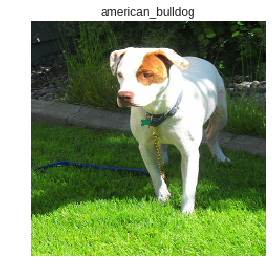

In [7]:
data.show_batch(rows=1)

In [0]:
idx = 0
x,y = next(iter(data.train_dl))

In [9]:
x[idx].shape

torch.Size([3, 224, 224])

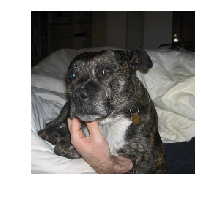

In [10]:
data.train_ds[idx][0].show()

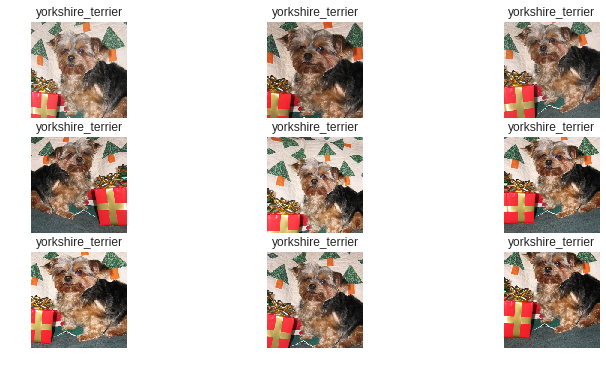

In [0]:
# Note to self: all 3 args are provided by plot_multi
def _draw(i, j, ax):
  image,label = data.train_ds[idx]
  image.show(ax, y=label)

plot_multi(_draw, 3, 3)

In [0]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)

In [0]:
learner.lr_find()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


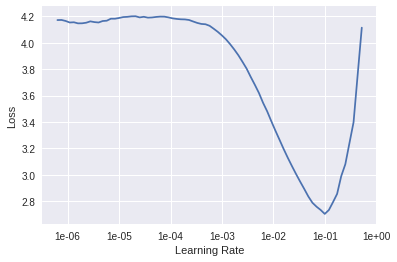

In [0]:
learner.recorder.plot()

In [0]:
from fastai.callbacks import SaveModelCallback
savemodel = SaveModelCallback(learner, name='v1')
learner.fit_one_cycle(5, 1e-2, callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.966045,0.411598
2,0.780338,0.944054
3,0.564213,0.398420
4,0.371702,0.261415
5,0.244874,0.228977


In [0]:
from fastai.callbacks import SaveModelCallback
savemodel = SaveModelCallback(learner, name='v2')
learner.fit_one_cycle(5, 1e-2, callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.294042,0.484165
2,0.649142,0.709901
3,0.492937,0.361621
4,0.337400,0.222926
5,0.233750,0.201046


In [0]:
learner.load('v2')
learner.freeze_to(-2)

In [0]:
savemodel = SaveModelCallback(learner, name='v3')
learner.fit_one_cycle(5, slice(1e-6,1e-4), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.207556,0.204741
2,0.213299,0.230598
3,0.179036,0.200956
4,0.144137,0.186919
5,0.116514,0.187792


In [0]:
learner.unfreeze()

In [0]:
learner.load('v3')
savemodel = SaveModelCallback(learner, name='v4')
learner.fit_one_cycle(5, slice(1e-6,1e-4), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.116348,0.180651
2,0.107225,0.179543
3,0.100443,0.183755
4,0.101394,0.180671
5,0.085117,0.180099


In [0]:
learner.load('v4')
savemodel = SaveModelCallback(learner, name='v5')
learner.fit_one_cycle(5, slice(1e-12,1e-6), callbacks=[savemodel])

epoch,train_loss,valid_loss
1,0.104065,0.178623
2,0.099733,0.179406
3,0.105761,0.179414
4,0.098666,0.178813
5,0.100943,0.181782


In [0]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)
learner.load('v2')
learner.validate()

[0.17862299, tensor(0.0602)]

In [0]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)

In [13]:
learner.load('v2')
learner.validate()

[0.092590876, tensor(0.0352)]

In [14]:
list(filter(lambda name: 'single' in name, dir(data)))

['single_dl', 'single_ds', 'single_from_classes']

In [15]:
# Note to self: so fast.ai actually structures head & backbone of the model to be separate sequential models
HEAD = 1
learner.model[HEAD]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=37, bias=True)
)

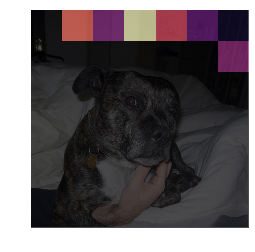

In [57]:
from fastai.callbacks.hooks import *
import pdb

# Note to self: model.eval() Sets the module in evaluation mode (e.g. Dropout)
class EvalModel(object):
    def __init__(self, model):
        self.model = model
        self.original_state = model.training
    def __enter__(self): self.model.eval()
    def __exit__(self, type, value, traceback): self.model.train(self.original_state)

# Note to self: hook_output can be used instead with less typing
def explain_image(example_image, category_id):
  image_tensor = example_image.px.cuda()
  single_image_batch = image_tensor[None]

  resnet_backbone = learner.model[0]

  with EvalModel(resnet_backbone),\
      hook_output(resnet_backbone, grad=False)  as backbone_activations_output,\
      hook_output(resnet_backbone, grad=True) as backbone_activations_gradient:
    preds = learner.model.forward(single_image_batch)
    # flow back the gradients for just the selected category
    preds_selected_category = preds[0, category_id]
    preds_selected_category.backward()

  # both are torch.Size([1, 512, 7, 7])
  activations = backbone_activations_output.stored
  gradients = backbone_activations_gradient.stored[0]

  # [1,512,7,7] -> [512]
  feature_importance = gradients.mean((0,2,3))

  # [512, 7, 7]
  weighted_features = feature_importance.unsqueeze(1).unsqueeze(1)*activations.squeeze()

  # [512,7,7]
  cam_mask = weighted_features.mean(0).contiguous().cpu()
  cam_mask = F.relu(cam_mask)
  
  _,ax = plt.subplots()
  example_image.show(ax)
  extent_right = example_image.size[0]
  extent_bottom = example_image.size[1]
  # https://matplotlib.org/tutorials/intermediate/imshow_extent.html
  # orient pixels & match mask size to the size of the image
  extent = (0, extent_right, extent_bottom, 0)
  ax.imshow(cam_mask, alpha=0.7, extent=extent, interpolation=None, cmap='magma')

def explain_image_by_idx(idx, category_id):
  IMAGE = 0
  explain_image(data.train_ds[idx][IMAGE], category_id)
  
def explain_image_by_name(fn, category_id):  
  x = open_image(fn)
  x.resize((224))
  explain_image(x, category_id)
  
explain_image_by_idx(0, category_id = 1)

In [19]:
data.classes[1]

'Bengal'

In [44]:
res = learner.predict(data.train_ds[0][0])
category = res[0]
probabilities = res[1]
category.data

tensor(34)

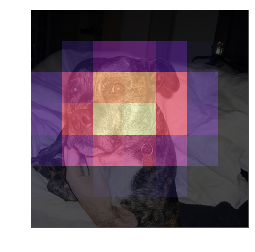

In [45]:
explain_image_by_idx(0, category_id = 34)

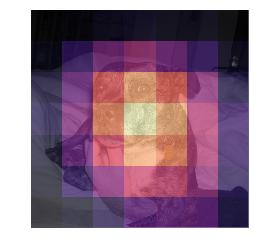

In [84]:
# just activations: 1) sum (not mean) 2) no class-specific grads & feature weighting

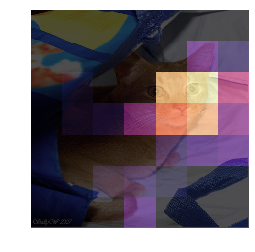

In [58]:
explain_image_by_name(path/'Abyssinian_100.jpg', category_id=0)

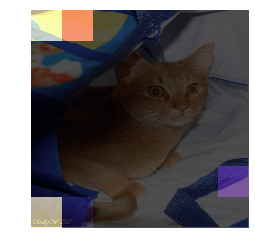

In [59]:
explain_image_by_name(path/'Abyssinian_100.jpg', category_id=34)